# *** READ ME ***
This kernel is optional and is used for the 2024 G3P in-situ evaluation.
This code allows to show the spatial correlations variation accross the aquifer, between in-situ GWLA and G3P GWSA. The Paris Basin is here take as an exemple.  
The inputs are: df_combined.xlsx (from kernel 1) ; .nc annual datasets from G3P ; Grids.shp ; G3P_Aquifers_SET2.shp ; Grids_G3P.shp
The outputs are: none

# *****************

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime
from shapely.geometry import Point
import rioxarray
import glob
from scipy.stats import pearsonr

# 1. Bringing 'df_combined' that has been saved in Kernel 1, and calculate time series for each cell

In [2]:
df_combined = pd.read_excel("df_combined.xlsx", index_col=0)
df_combined

,date,GWLA,sy_min,sy_ave,minGWSA,aveGWSA,latitude,longitude
ID,,,,,,,,
00107X0006/P1,2002-04-30,12.657182,0.010383,0.057217,131.423745,724.201790,50.599128,1.680733
00107X0006/P1,2002-05-31,6.577182,0.010383,0.057217,68.293078,376.324456,50.599128,1.680733
00107X0006/P1,2002-06-30,2.142182,0.010383,0.057217,22.242995,122.568540,50.599128,1.680733
00107X0006/P1,2002-07-31,-0.234818,0.010383,0.057217,-2.438189,-13.435477,50.599128,1.680733
00107X0006/P1,2002-08-31,-1.295318,0.010383,0.057217,-13.449714,-74.113752,50.599128,1.680733
...,...,...,...,...,...,...,...,...
06143X0011/S,2023-05-31,-0.412872,0.046325,0.140008,-19.126276,-57.805462,46.434841,0.912525
06143X0011/S,2023-06-30,-0.610538,0.046325,0.140008,-28.283184,-85.480442,46.434841,0.912525
06143X0011/S,2023-07-31,-0.872226,0.046325,0.140008,-40.405889,-122.118967,46.434841,0.912525


In [3]:
import geopandas as gpd
import pandas as pd

grids = gpd.read_file('Grids.shp')

# Convert piezometer data to GeoDataFrame (if not already)
df_combined = gpd.GeoDataFrame(df_combined, geometry=gpd.points_from_xy(df_combined['longitude'], df_combined['latitude']))

# Make a spatial join to associate each piezometer with a grid cell
df_final = gpd.sjoin(df_combined, grids, how='left', predicate='within')

# Calculate monthly averages for each grid cell
mean_monthly = df_final.groupby([df_final['date'].dt.to_period('M'), 'index_right'])['GWLA'].mean().reset_index()
mean_monthly['date'] = mean_monthly['date'].dt.to_timestamp()

# Merge with grid to get geometry
mean_monthly_gdf = mean_monthly.merge(grids, left_on='index_right', right_index=True)
mean_monthly_gdf = gpd.GeoDataFrame(mean_monthly_gdf)
mean_monthly_gdf

,date,index_right,GWLA,geometry
0,2002-04-01,2,2.424611,"POLYGON ((-1.14397 49.70583, -0.64397 49.70583..."
86,2002-05-01,2,0.776403,"POLYGON ((-1.14397 49.70583, -0.64397 49.70583..."
172,2002-06-01,2,-0.199995,"POLYGON ((-1.14397 49.70583, -0.64397 49.70583..."
258,2002-07-01,2,-0.439081,"POLYGON ((-1.14397 49.70583, -0.64397 49.70583..."
344,2002-08-01,2,-0.632710,"POLYGON ((-1.14397 49.70583, -0.64397 49.70583..."
...,...,...,...,...
20897,2023-05-01,164,-0.082530,"POLYGON ((6.85603 48.70583, 7.35603 48.70583, ..."
20983,2023-06-01,164,-0.080885,"POLYGON ((6.85603 48.70583, 7.35603 48.70583, ..."
21069,2023-07-01,164,-0.128014,"POLYGON ((6.85603 48.70583, 7.35603 48.70583, ..."
21155,2023-08-01,164,-0.183820,"POLYGON ((6.85603 48.70583, 7.35603 48.70583, ..."


In [4]:
# Pivot to make the df more easy to read
insitu_df = mean_monthly_gdf.pivot_table(index='date', columns='geometry', values='GWLA')
insitu_df.index = [index.strftime('%Y-%m') for index in insitu_df.index]
insitu_df

geometry,"POLYGON ((-0.14397 46.70583, 0.35603 46.70583,...","POLYGON ((-0.14397 47.20583, 0.35603 47.20583,...","POLYGON ((-0.14397 47.70583, 0.35603 47.70583,...","POLYGON ((0.35603 47.70583, 0.85603 47.70583, ...","POLYGON ((0.85603 47.70583, 1.35603 47.70583, ...","POLYGON ((0.85603 47.20583, 1.35603 47.20583, ...","POLYGON ((0.35603 47.20583, 0.85603 47.20583, ...","POLYGON ((0.35603 46.70583, 0.85603 46.70583, ...","POLYGON ((0.85603 46.70583, 1.35603 46.70583, ...","POLYGON ((1.35603 47.20583, 1.85603 47.20583, ...",...,"POLYGON ((5.35603 48.20583, 5.85603 48.20583, ...","POLYGON ((5.35603 48.70583, 5.85603 48.70583, ...","POLYGON ((4.85603 48.70583, 5.35603 48.70583, ...","POLYGON ((4.35603 48.70583, 4.85603 48.70583, ...","POLYGON ((3.85603 48.70583, 4.35603 48.70583, ...","POLYGON ((3.35603 48.70583, 3.85603 48.70583, ...","POLYGON ((3.85603 48.20583, 4.35603 48.20583, ...","POLYGON ((3.35603 48.20583, 3.85603 48.20583, ...","POLYGON ((4.35603 48.20583, 4.85603 48.20583, ...","POLYGON ((4.85603 47.70583, 5.35603 47.70583, ..."
2002-04,2.485557,0.559977,0.515655,2.223902,1.286947,1.585602,0.533556,0.665792,1.834888,0.424092,...,0.425001,-0.517939,0.141514,2.820584,5.604694,7.302887,0.169097,0.938685,0.425151,0.902794
2002-05,1.175598,0.211962,0.289996,2.036349,1.076010,1.354655,0.819150,0.492225,1.511043,-0.192536,...,0.388834,-0.802105,-0.117669,2.590352,3.999742,6.169183,-0.677732,0.620249,-0.449817,-2.632048
2002-06,1.151291,0.021977,0.096466,1.651694,0.879517,1.291869,0.757295,0.306959,1.533510,-0.135927,...,0.355501,-1.641272,-0.317486,2.074250,2.822305,4.853517,-0.738022,0.442702,-0.792849,-4.117706
2002-07,-1.699724,-0.972954,-0.099223,0.744067,0.144800,0.709905,0.432380,-0.021727,1.187766,-1.244393,...,0.319001,-1.866272,-0.464996,1.285998,1.456059,3.624506,-0.999022,0.230518,-0.950139,-4.721206
2002-08,-3.251466,-1.403026,-0.059475,0.946433,0.191382,0.673970,0.471716,-0.178743,0.768634,-1.633856,...,0.294668,-1.859772,-0.369443,0.434163,-0.684209,2.323982,-1.052248,0.307185,-1.080462,-5.003667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05,1.688621,0.357892,0.161489,0.912022,-0.290579,-1.079246,-0.904781,-0.431727,-1.311585,-0.003439,...,0.541496,-0.409498,0.078460,0.384002,-0.457596,0.097812,0.537268,-0.505160,-0.494978,-2.292948
2023-06,-0.104876,-0.012305,-0.059396,-1.626941,-0.745859,-1.606504,-0.737724,-0.679041,-1.644109,-0.673390,...,0.511001,-1.623772,-0.266820,0.481459,-1.159417,-0.747233,-0.737855,-0.712482,-0.640849,-4.190206
2023-07,-1.977079,-0.483342,-0.243350,-2.105397,-0.930579,-1.335956,-0.866359,-0.917407,-4.304165,-1.080607,...,0.482786,-1.874175,-0.428476,0.092066,-1.936951,-2.251220,-0.804183,-0.844912,-0.784010,-4.926174
2023-08,-2.548468,-0.743491,-0.401737,-2.222252,-0.955135,-1.494665,-0.955713,-1.160598,-5.738553,-1.456736,...,0.529560,-1.183208,-0.317346,-0.467289,-1.263725,-2.303720,-0.081925,-0.795719,-0.883365,-5.274883


# 2. Creating the map

<Axes: >

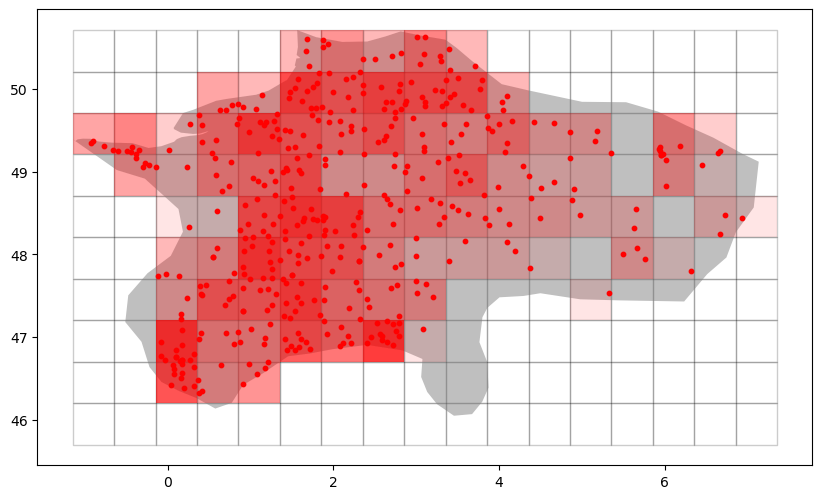

In [5]:
# Charger les fichiers shapefile
grids = gpd.read_file('Grids.shp')
aquifer = gpd.read_file('G3P_Aquifers_SET2.shp')
Grids_G3P = gpd.read_file('Grids_G3P.shp')
locations = df_combined.copy().drop(columns=['date', 'GWLA']).groupby('ID').first().rename(columns={'latitude': 'lat', 'longitude': 'long'})

# Convertir les données des piezomètres en GeoDataFrame
geometry = gpd.points_from_xy(locations.long, locations.lat)
piezometers = gpd.GeoDataFrame(locations, geometry=geometry)

# Créer la carte
fig, ax = plt.subplots(figsize=(10, 10))

grids.plot(ax=ax, color='none', edgecolor='black', alpha=0.2)
aquifer.plot(ax=ax, color='grey', alpha=0.5, label='Aquifer')
Grids_G3P.plot(ax=ax, color='red', edgecolor='none', alpha=0.1)
piezometers.plot(ax=ax, color='red', markersize=10, label='Piezometers')

# 3. Bringing G3P, and calculate time series for each cell

In [6]:
shp = gpd.read_file('Grids_G3P.shp')
shp.crs = 'EPSG:4326'
shp_wgs = shp.to_crs(epsg=4326)

G3P_df = pd.DataFrame()

# Get list of .nc files in same directory as script
file_list = glob.glob('*.nc')

# Loop through .netCDF files
for file_path in file_list:
    # Load .netCDF file
    dataset = rioxarray.open_rasterio(file_path)
    dataset.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
    dataset.rio.write_crs("epsg:4326", inplace=True)

    # Clip the .netCDF with the shapefile
    clipped_data = dataset.rio.clip(shp_wgs.geometry, shp_wgs.crs, drop=False)

    # Extract dates
    time_coords = clipped_data.coords['time'].values

    # Initialize a DataFrame with dates as index
    df = pd.DataFrame(index=time_coords)

    # Loop through every single cell of the shapefile
    for index, cell in shp_wgs.iterrows():
        # Get the centroid of the cell
        centroid = cell.geometry.centroid

        # Extract cell data using centroid coordinates
        cell_data = clipped_data.sel(x=centroid.x, y=centroid.y, method='nearest')

        # Get GWSA variable values
        gwsa_values = cell_data['GWSA'].values

        # Add the values ​​to the DataFrame
        df[cell.geometry] = gwsa_values

    # Ajouter les données de chaque fichier au DataFrame final
    G3P_df = pd.concat([G3P_df, df], axis=0)

G3P_df.index = [index.strftime('%Y-%m') for index in G3P_df.index]
G3P_df = G3P_df.rename_axis('Date', axis='index').rename_axis('geometry', axis='columns')
G3P_df

geometry,"POLYGON ((-1.143969698 49.705827482, -0.643969698 49.705827482, -0.643969698 49.205827482, -1.143969698 49.205827482, -1.143969698 49.705827482))","POLYGON ((-0.643969698 49.705827482, -0.143969698 49.705827482, -0.143969698 49.205827482, -0.643969698 49.205827482, -0.643969698 49.705827482))","POLYGON ((-0.643969698 49.205827482, -0.143969698 49.205827482, -0.143969698 48.705827482, -0.643969698 48.705827482, -0.643969698 49.205827482))","POLYGON ((-0.143969698 49.705827482, 0.356030302 49.705827482, 0.356030302 49.205827482, -0.143969698 49.205827482, -0.143969698 49.705827482))","POLYGON ((-0.143969698 49.205827482, 0.356030302 49.205827482, 0.356030302 48.705827482, -0.143969698 48.705827482, -0.143969698 49.205827482))","POLYGON ((-0.143969698 48.705827482, 0.356030302 48.705827482, 0.356030302 48.205827482, -0.143969698 48.205827482, -0.143969698 48.705827482))","POLYGON ((-0.143969698 48.205827482, 0.356030302 48.205827482, 0.356030302 47.705827482, -0.143969698 47.705827482, -0.143969698 48.205827482))","POLYGON ((-0.143969698 47.705827482, 0.356030302 47.705827482, 0.356030302 47.205827482, -0.143969698 47.205827482, -0.143969698 47.705827482))","POLYGON ((-0.143969698 47.205827482, 0.356030302 47.205827482, 0.356030302 46.705827482, -0.143969698 46.705827482, -0.143969698 47.205827482))","POLYGON ((-0.143969698 46.705827482, 0.356030302 46.705827482, 0.356030302 46.205827482, -0.143969698 46.205827482, -0.143969698 46.705827482))",...,"POLYGON ((4.856030302 47.705827482, 5.356030302 47.705827482, 5.356030302 47.205827482, 4.856030302 47.205827482, 4.856030302 47.705827482))","POLYGON ((5.356030302 48.705827482, 5.856030302 48.705827482, 5.856030302 48.205827482, 5.356030302 48.205827482, 5.356030302 48.705827482))","POLYGON ((5.356030302 48.205827482, 5.856030302 48.205827482, 5.856030302 47.705827482, 5.356030302 47.705827482, 5.356030302 48.205827482))","POLYGON ((5.856030302 49.705827482, 6.356030302 49.705827482, 6.356030302 49.205827482, 5.856030302 49.205827482, 5.856030302 49.705827482))","POLYGON ((5.856030302 49.205827482, 6.356030302 49.205827482, 6.356030302 48.705827482, 5.856030302 48.705827482, 5.856030302 49.205827482))","POLYGON ((5.856030302 48.205827482, 6.356030302 48.205827482, 6.356030302 47.705827482, 5.856030302 47.705827482, 5.856030302 48.205827482))","POLYGON ((6.356030302 49.705827482, 6.856030302 49.705827482, 6.856030302 49.205827482, 6.356030302 49.205827482, 6.356030302 49.705827482))","POLYGON ((6.356030302 49.205827482, 6.856030302 49.205827482, 6.856030302 48.705827482, 6.356030302 48.705827482, 6.356030302 49.205827482))","POLYGON ((6.356030302 48.705827482, 6.856030302 48.705827482, 6.856030302 48.205827482, 6.356030302 48.205827482, 6.356030302 48.705827482))","POLYGON ((6.856030302 48.705827482, 7.356030302 48.705827482, 7.356030302 48.205827482, 6.856030302 48.205827482, 6.856030302 48.705827482))"
Date,,,,,,,,,,,,,,,,,,,,,
2002-04,30.462431,32.658709,26.039677,34.897856,28.850997,21.451788,13.957520,6.890406,0.561862,-4.825095,...,31.386946,38.271863,32.754464,42.982591,39.281298,27.584997,40.396102,35.664622,29.415896,24.632777
2002-05,14.554888,17.013614,13.458838,19.711974,17.138206,14.112623,11.728004,10.067139,8.949189,8.022920,...,64.095306,63.845742,64.226620,60.896481,63.145570,63.270350,62.357842,63.664691,63.430958,62.467026
2002-08,37.103375,42.585962,37.965828,47.796591,43.764972,38.538753,32.613978,25.858711,18.295308,10.179094,...,84.204512,91.666995,90.115802,89.449727,92.072961,91.170985,90.262573,92.728427,93.287203,93.405753
2002-09,38.103944,40.219915,36.863539,42.196916,39.167412,35.171896,30.497210,24.843984,18.117065,10.531688,...,64.344920,69.806276,69.033302,67.759849,70.026173,70.373431,68.560335,70.841034,71.890054,72.595221
2002-10,13.169799,17.789157,18.128989,22.982781,24.031419,24.323265,24.118957,23.053355,20.941017,17.877543,...,93.081928,91.405868,93.881133,83.109498,88.507220,94.530413,84.139145,89.122454,92.599346,92.321517
...,...,.

In [7]:
# insitu_df reducing, to adapt to G3P df dimensions (due to NaN months due to instrumental errors and generations switch)
insitu_df_reduced = insitu_df.loc[G3P_df.index.intersection(insitu_df.index)]
insitu_df_reduced

geometry,"POLYGON ((-0.14397 46.70583, 0.35603 46.70583,...","POLYGON ((-0.14397 47.20583, 0.35603 47.20583,...","POLYGON ((-0.14397 47.70583, 0.35603 47.70583,...","POLYGON ((0.35603 47.70583, 0.85603 47.70583, ...","POLYGON ((0.85603 47.70583, 1.35603 47.70583, ...","POLYGON ((0.85603 47.20583, 1.35603 47.20583, ...","POLYGON ((0.35603 47.20583, 0.85603 47.20583, ...","POLYGON ((0.35603 46.70583, 0.85603 46.70583, ...","POLYGON ((0.85603 46.70583, 1.35603 46.70583, ...","POLYGON ((1.35603 47.20583, 1.85603 47.20583, ...",...,"POLYGON ((5.35603 48.20583, 5.85603 48.20583, ...","POLYGON ((5.35603 48.70583, 5.85603 48.70583, ...","POLYGON ((4.85603 48.70583, 5.35603 48.70583, ...","POLYGON ((4.35603 48.70583, 4.85603 48.70583, ...","POLYGON ((3.85603 48.70583, 4.35603 48.70583, ...","POLYGON ((3.35603 48.70583, 3.85603 48.70583, ...","POLYGON ((3.85603 48.20583, 4.35603 48.20583, ...","POLYGON ((3.35603 48.20583, 3.85603 48.20583, ...","POLYGON ((4.35603 48.20583, 4.85603 48.20583, ...","POLYGON ((4.85603 47.70583, 5.35603 47.70583, ..."
2002-04,2.485557,0.559977,0.515655,2.223902,1.286947,1.585602,0.533556,0.665792,1.834888,0.424092,...,0.425001,-0.517939,0.141514,2.820584,5.604694,7.302887,0.169097,0.938685,0.425151,0.902794
2002-05,1.175598,0.211962,0.289996,2.036349,1.076010,1.354655,0.819150,0.492225,1.511043,-0.192536,...,0.388834,-0.802105,-0.117669,2.590352,3.999742,6.169183,-0.677732,0.620249,-0.449817,-2.632048
2002-08,-3.251466,-1.403026,-0.059475,0.946433,0.191382,0.673970,0.471716,-0.178743,0.768634,-1.633856,...,0.294668,-1.859772,-0.369443,0.434163,-0.684209,2.323982,-1.052248,0.307185,-1.080462,-5.003667
2002-09,-2.480376,-1.345444,0.012408,1.095950,0.344310,0.799394,0.504958,-0.195541,0.592882,-1.379394,...,0.241834,-1.966272,-0.412986,-0.375708,-0.695751,1.463100,-1.155189,0.712185,-1.198515,-5.340206
2002-10,-2.093402,-1.205178,-0.107699,0.901276,0.481977,0.938955,0.587970,-0.299307,0.549492,-1.411875,...,0.261001,-1.232105,-0.509121,-1.101482,-2.067032,0.424687,-1.209045,1.142185,-1.264655,-5.277706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05,1.688621,0.357892,0.161489,0.912022,-0.290579,-1.079246,-0.904781,-0.431727,-1.311585,-0.003439,...,0.541496,-0.409498,0.078460,0.384002,-0.457596,0.097812,0.537268,-0.505160,-0.494978,-2.292948
2023-06,-0.104876,-0.012305,-0.059396,-1.626941,-0.745859,-1.606504,-0.737724,-0.679041,-1.644109,-0.673390,...,0.511001,-1.623772,-0.266820,0.481459,-1.159417,-0.747233,-0.737855,-0.712482,-0.640849,-4.190206
2023-07,-1.977079,-0.483342,-0.243350,-2.105397,-0.930579,-1.335956,-0.866359,-0.917407,-4.304165,-1.080607,...,0.482786,-1.874175,-0.428476,0.092066,-1.936951,-2.251220,-0.804183,-0.844912,-0.784010,-4.926174
2023-08,-2.548468,-0.743491,-0.401737,-2.222252,-0.955135,-1.494665,-0.955713,-1.160598,-5.738553,-1.456736,...,0.529560,-1.183208,-0.317346,-0.467289,-1.263725,-2.303720,-0.081925,-0.795719,-0.883365,-5.274883


# 4. Pearson correlation calculation

In [8]:
# Initialize a DataFrame to store results
correlation_df = pd.DataFrame(index=['Pearson'], columns=G3P_df.columns)

# Iterate through each column of result_df
for polygon1 in G3P_df.columns:
    # Cycle through each column of insitu_df_reduced
    for polygon2 in insitu_df_reduced.columns:
        # Calculate the intersection between the two polygons
        intersection_area = polygon1.intersection(polygon2).area
        # Calculate the total area of ​​each polygon
        area1 = polygon1.area
        area2 = polygon2.area
        # Calculate overlap percentage
        overlap_percentage = (intersection_area / min(area1, area2)) * 100
        
    
        if overlap_percentage > 50 :
            # Extract the time series associated with polygon1 and polygon2
            series1 = G3P_df[polygon1]
            series2 = insitu_df_reduced[polygon2]
            try:
                # Calculate the Pearson correlation coefficient between time series
                correlation, _ = pearsonr(series1, series2)
            except ValueError:
                # If an error occurs, put NaN. This can be due to some cell located too close to the sea/ocean
                correlation = np.nan
            
            # Store correlation coefficient in correlation_df
            correlation_df.loc['Pearson', polygon2] = correlation
            if correlation < -0.3:
                # Create an empty DataFrame
                    save_df = pd.DataFrame(index=series1.index)
                    # Assign time series to corresponding columns
                    save_df['G3P'] = series1.values
                    save_df['in-situ'] = series2.values

# Show the DataFrame containing the correlation coefficients
transposed_correlation_df = correlation_df.transpose().reset_index()
transposed_correlation_df = gpd.GeoDataFrame(transposed_correlation_df, geometry='geometry')
transposed_correlation_df

,geometry,Pearson
0,"POLYGON ((-1.14397 49.70583, -0.64397 49.70583...",0.418472
1,"POLYGON ((-0.64397 49.70583, -0.14397 49.70583...",0.462259
2,"POLYGON ((-0.64397 49.20583, -0.14397 49.20583...",0.444423
3,"POLYGON ((-0.14397 49.70583, 0.35603 49.70583,...",0.693378
4,"POLYGON ((-0.14397 49.20583, 0.35603 49.20583,...",0.390181
...,...,...
81,"POLYGON ((5.85603 48.20583, 6.35603 48.20583, ...",0.452547
82,"POLYGON ((6.35603 49.70583, 6.85603 49.70583, ...",0.103528
83,"POLYGON ((6.35603 49.20583, 6.85603 49.20583, ...",0.546996
84,"POLYGON ((6.35603 48.70583, 6.85603 48.70583, ...",0.584799


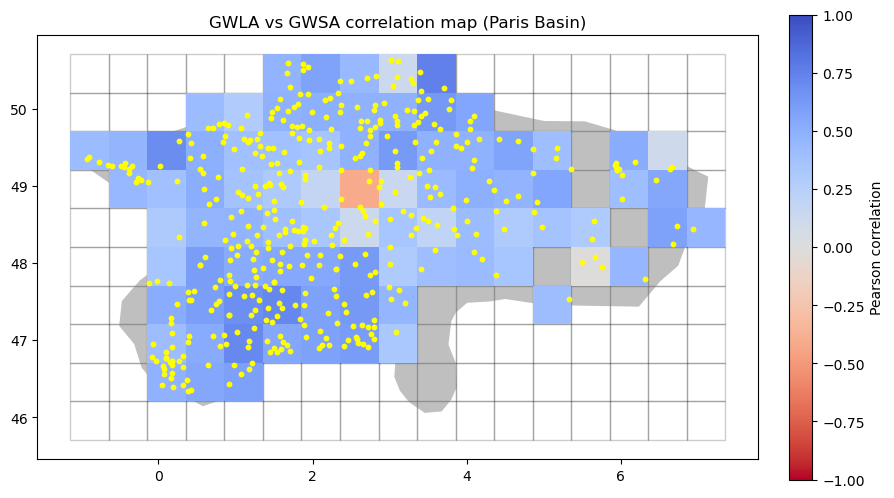

In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import pandas as pd

# Convert 'Pearson' column to float type
transposed_correlation_df['Pearson'] = pd.to_numeric(transposed_correlation_df['Pearson'], errors='coerce')

# Determine the minimum and maximum values ​​for the colorbar
min_val = -1
max_val = 1

fig, ax = plt.subplots(figsize=(10, 10))
grids.plot(ax=ax, color='none', edgecolor='black', alpha=0.2)
aquifer.plot(ax=ax, color='grey', alpha=0.5, label='Aquifer')
plot = transposed_correlation_df.plot(ax=ax, column='Pearson', cmap='coolwarm_r', legend=False, vmin=min_val, vmax=max_val)
piezometers.plot(ax=ax, color='yellow', markersize=10, label='Piezometers')

# Create a colorbar with specified limits
cbar = plt.colorbar(ScalarMappable(norm=Normalize(vmin=min_val, vmax=max_val), cmap='coolwarm_r'), ax=ax, orientation='vertical', fraction=0.03, pad=0.04, label='Pearson correlation')

plt.title('GWLA vs GWSA correlation map (Paris Basin)')
plt.show()

In [10]:
print(f"Min: {transposed_correlation_df['Pearson'].min()}, Max: {transposed_correlation_df['Pearson'].max()}, Median: {transposed_correlation_df['Pearson'].median()}, Mean: {transposed_correlation_df['Pearson'].mean()}")

Min: -0.40978746151740975, Max: 0.7570229856436643, Median: 0.4659108568020377, Mean: 0.4424200868891717
